Dataset Shape: (768, 9)
Missing Values: 0
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:37:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}
Accuracy: 0.74


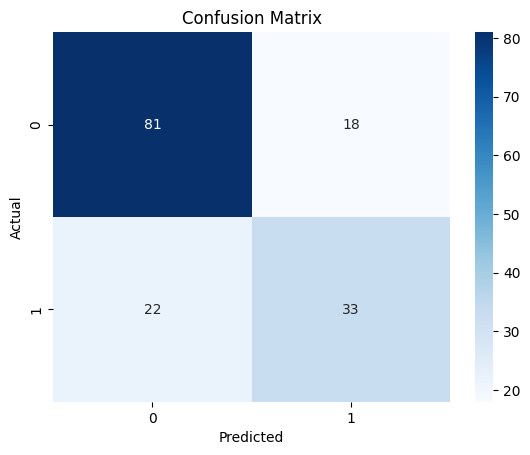

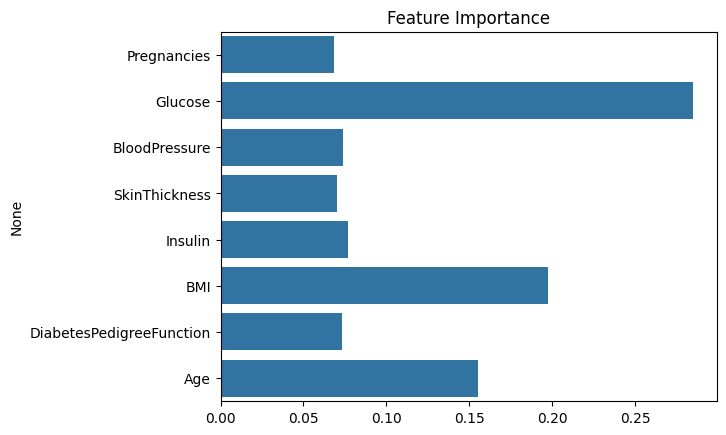

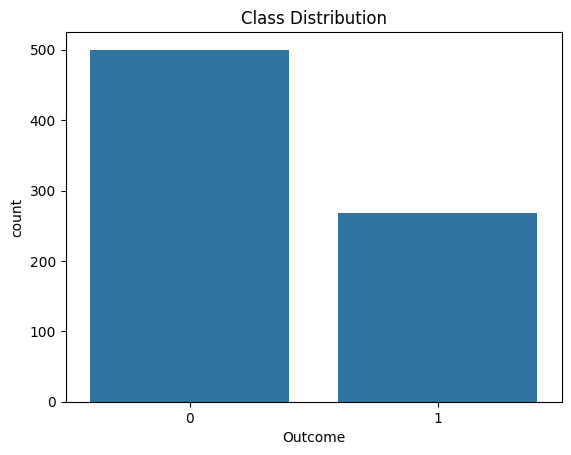

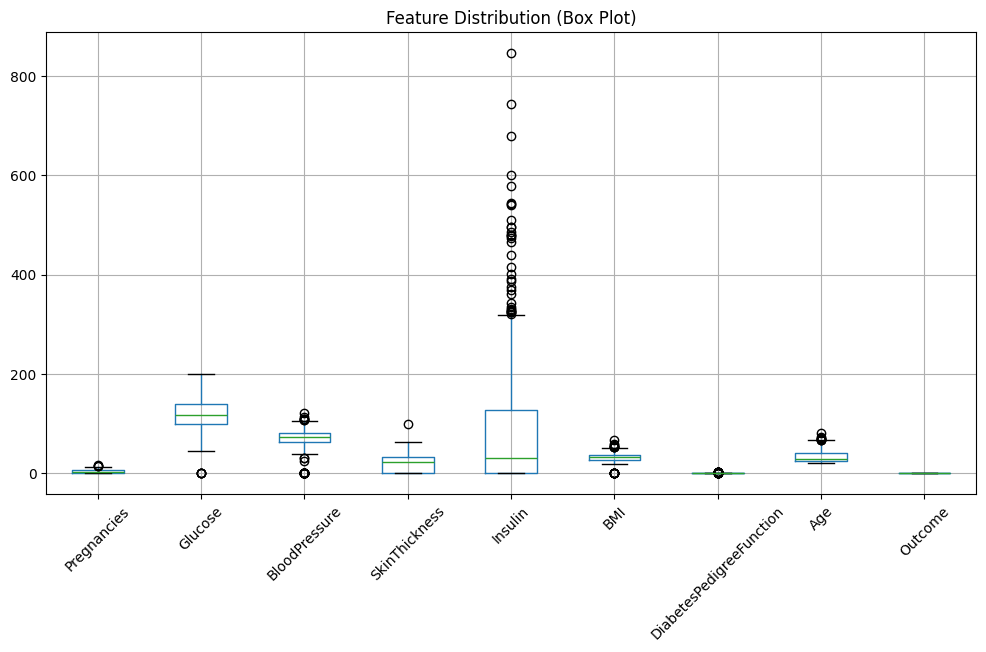

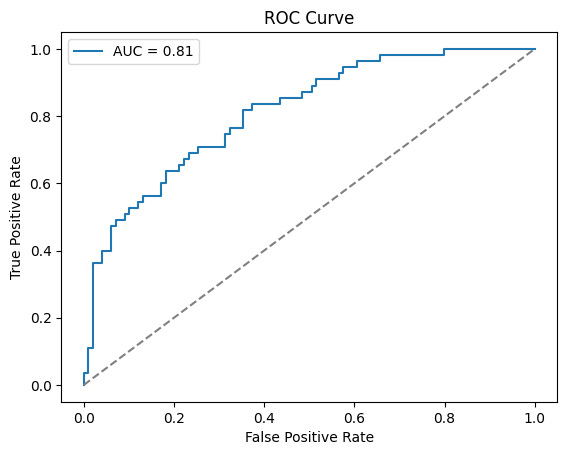

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.80        99
           1       0.65      0.60      0.62        55

    accuracy                           0.74       154
   macro avg       0.72      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score

# Load dataset
df = pd.read_csv('diabetes.csv')  # Adjust if needed

# Display basic information
print("Dataset Shape:", df.shape)
print("Missing Values:", df.isnull().sum().sum())
print(df.head())

# Handling missing values (if any)
df.fillna(df.mean(), inplace=True)  # Fill missing values with column mean

# Splitting dataset
X = df.iloc[:, :-1]  # Assuming last column is target
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                           param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Train best model on full training data
xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)

# Save model as pickle
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance
importances = xgb.feature_importances_
feature_names = df.columns[:-1]
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.show()

# Class Distribution
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()

# Box Plot
plt.figure(figsize=(12,6))
df.boxplot()
plt.title("Feature Distribution (Box Plot)")
plt.xticks(rotation=45)
plt.show()

# ROC Curve
y_probs = xgb.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))
